In [1]:
import os
import json
import time
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import torch.nn as nn

from torch.nn import L1Loss
from monai.utils import set_determinism, first
from monai.networks.nets import ViTAutoEnc
from monai.losses import ContrastiveLoss
from monai.data import DataLoader, Dataset
from monai.config import print_config
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    RandRotated,
    RandZoomd
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
# print_config()

In [42]:
from monai.networks.nets import SwinUNETR
from monai.networks.blocks import PatchEmbed

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=3,
    feature_size=48,
    use_checkpoint=True,
)



In [58]:
from monai.networks.nets.swin_unetr import SwinTransformer as SwinViT

swinViT = SwinViT(
            in_chans=1,
            embed_dim=48,
            window_size=(7, 7, 7),
            patch_size=(2, 2,2 ),
            depths=[2, 2, 2, 2],
            num_heads=[3, 6, 12, 24],
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=0.0,
            attn_drop_rate=0.0,
            drop_path_rate=0.0,
            norm_layer=torch.nn.LayerNorm,
            use_checkpoint=False,
            spatial_dims=3,
)

In [73]:
weights = torch.load("/raid/deva/logs/pre_train/swin/model_swinvit.pt")
old_sd = weights["state_dict"].keys()
print(len(old_sd))

# rename weights keys by removing "module."
new_sd = {}
for k in old_sd:
    new_sd[k.replace("module.", "")] = weights["state_dict"][k]

new_new_sd = {}

for k in new_sd.keys():
    if "fc1" in k:
        new_new_sd[k.replace("fc1", "linear1")] = new_sd[k]
    elif "fc2" in k:
        new_new_sd[k.replace("fc2", "linear2")] = new_sd[k]
    else:
        new_new_sd[k] = new_sd[k]

len(new_new_sd.keys())

134


134

In [79]:
# save the new weights
torch.save(new_new_sd, "/raid/deva/logs/pre_train/swin/swinvit_new.pt")

In [75]:
swinViT.load_state_dict(new_new_sd, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['norm.weight', 'norm.bias', 'convTrans3d.weight', 'convTrans3d.bias', 'rotation_head.weight', 'rotation_head.bias', 'contrastive_head.weight', 'contrastive_head.bias'])

In [3]:
BRAIN_ROOT = "/scratch/Task1/brain/"
LOG_ROOT = "/scratch/MSD/logs"
set_determinism(seed=123)

def move_files_to_root():
    for x in os.listdir(BRAIN_ROOT):
        if "overview" not in x:
            for itm in os.listdir(BRAIN_ROOT + x):
                src = os.path.join(BRAIN_ROOT + x, itm)
                dest = os.path.join(BRAIN_ROOT, x + "_" + itm)
                os.rename(src, dest)

def get_files_list():
    masks, mris, cts = [], [], []

    for x in os.listdir(BRAIN_ROOT):
        if "mask" in x:
            masks.append(os.path.join(BRAIN_ROOT, x))
        elif "mr" in x:
            mris.append(os.path.join(BRAIN_ROOT, x))
        elif "ct" in x:
            cts.append(os.path.join(BRAIN_ROOT, x))

    masks.sort(); mris.sort(); cts.sort()
    return masks, mris, cts

def create_samples(inp_list, ids):
    samples = []
    for x in inp_list:
        if x.split("_")[0] in ids:
            samples.append({"image": x})
    return samples

def rescale_image(images, min_val, max_val):
    for i in tqdm(range(len(images))):
        img = sitk.ReadImage(images[i])
        img = sitk.GetArrayFromImage(img)
        img = (img - min_val) / (max_val - min_val)
        img = sitk.GetImageFromArray(img)
        sitk.WriteImage(img, images[i])

def check_image_range(images):
    minn, maxx = np.inf, -np.inf
    for i in tqdm(range(len(images))):
        img = nib.load(images[i])
        data = img.get_fdata()
        minn = min(minn, data.min())
        maxx = max(maxx, data.max())
        del img
    print(minn, maxx)


In [4]:
# move_files_to_root()
masks, mris, cts = get_files_list()

ids = [x.split("_")[0] for x in masks]
train_ids, test_ids = train_test_split(ids, test_size=0.1, random_state=123)

train_masks = create_samples(masks, train_ids)
train_mris = create_samples(mris, train_ids)
train_cts = create_samples(cts, train_ids)

test_masks = create_samples(masks, test_ids)
test_mris = create_samples(mris, test_ids)
test_cts = create_samples(cts, test_ids)

In [4]:
rescale_image(mris, 0.0, 3000.0)
rescale_image(cts, -1024.0, 3000.0)

100%|██████████| 180/180 [02:30<00:00,  1.19it/s]


##### Define MONAI Transforms 

In [4]:
# Define Training Transforms
train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Spacingd(keys=["image"], pixdim=(2.0, 2.0, 2.0), mode=("bilinear")),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=(128, 128, 128)),
        RandSpatialCropSamplesd(keys=["image"], roi_size=(128, 128, 128), random_size=False, num_samples=2),
        RandRotated(keys=["image"], range_x=90, range_y=90, range_z=90, prob=0.5, keep_size=True),
        RandZoomd(keys=["image"], min_zoom=0.8, max_zoom=1.2, prob=0.4, keep_size=True),
        CopyItemsd(keys=["image"], times=2, names=["gt_image", "image_2"], allow_missing_keys=False),
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image"], prob=0.8, holes=10, spatial_size=8),
        # Please note that that if image, image_2 are called via the same transform call because of the determinism
        # they will get augmented the exact same way which is not the required case here, hence two calls are made
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image_2"], prob=0.8, holes=10, spatial_size=8),
    ]
)


check_ds = Dataset(data=train_mris, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image = check_data["image"][0][0]
print(f"image shape: {image.shape}")

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


image shape: torch.Size([128, 128, 128])


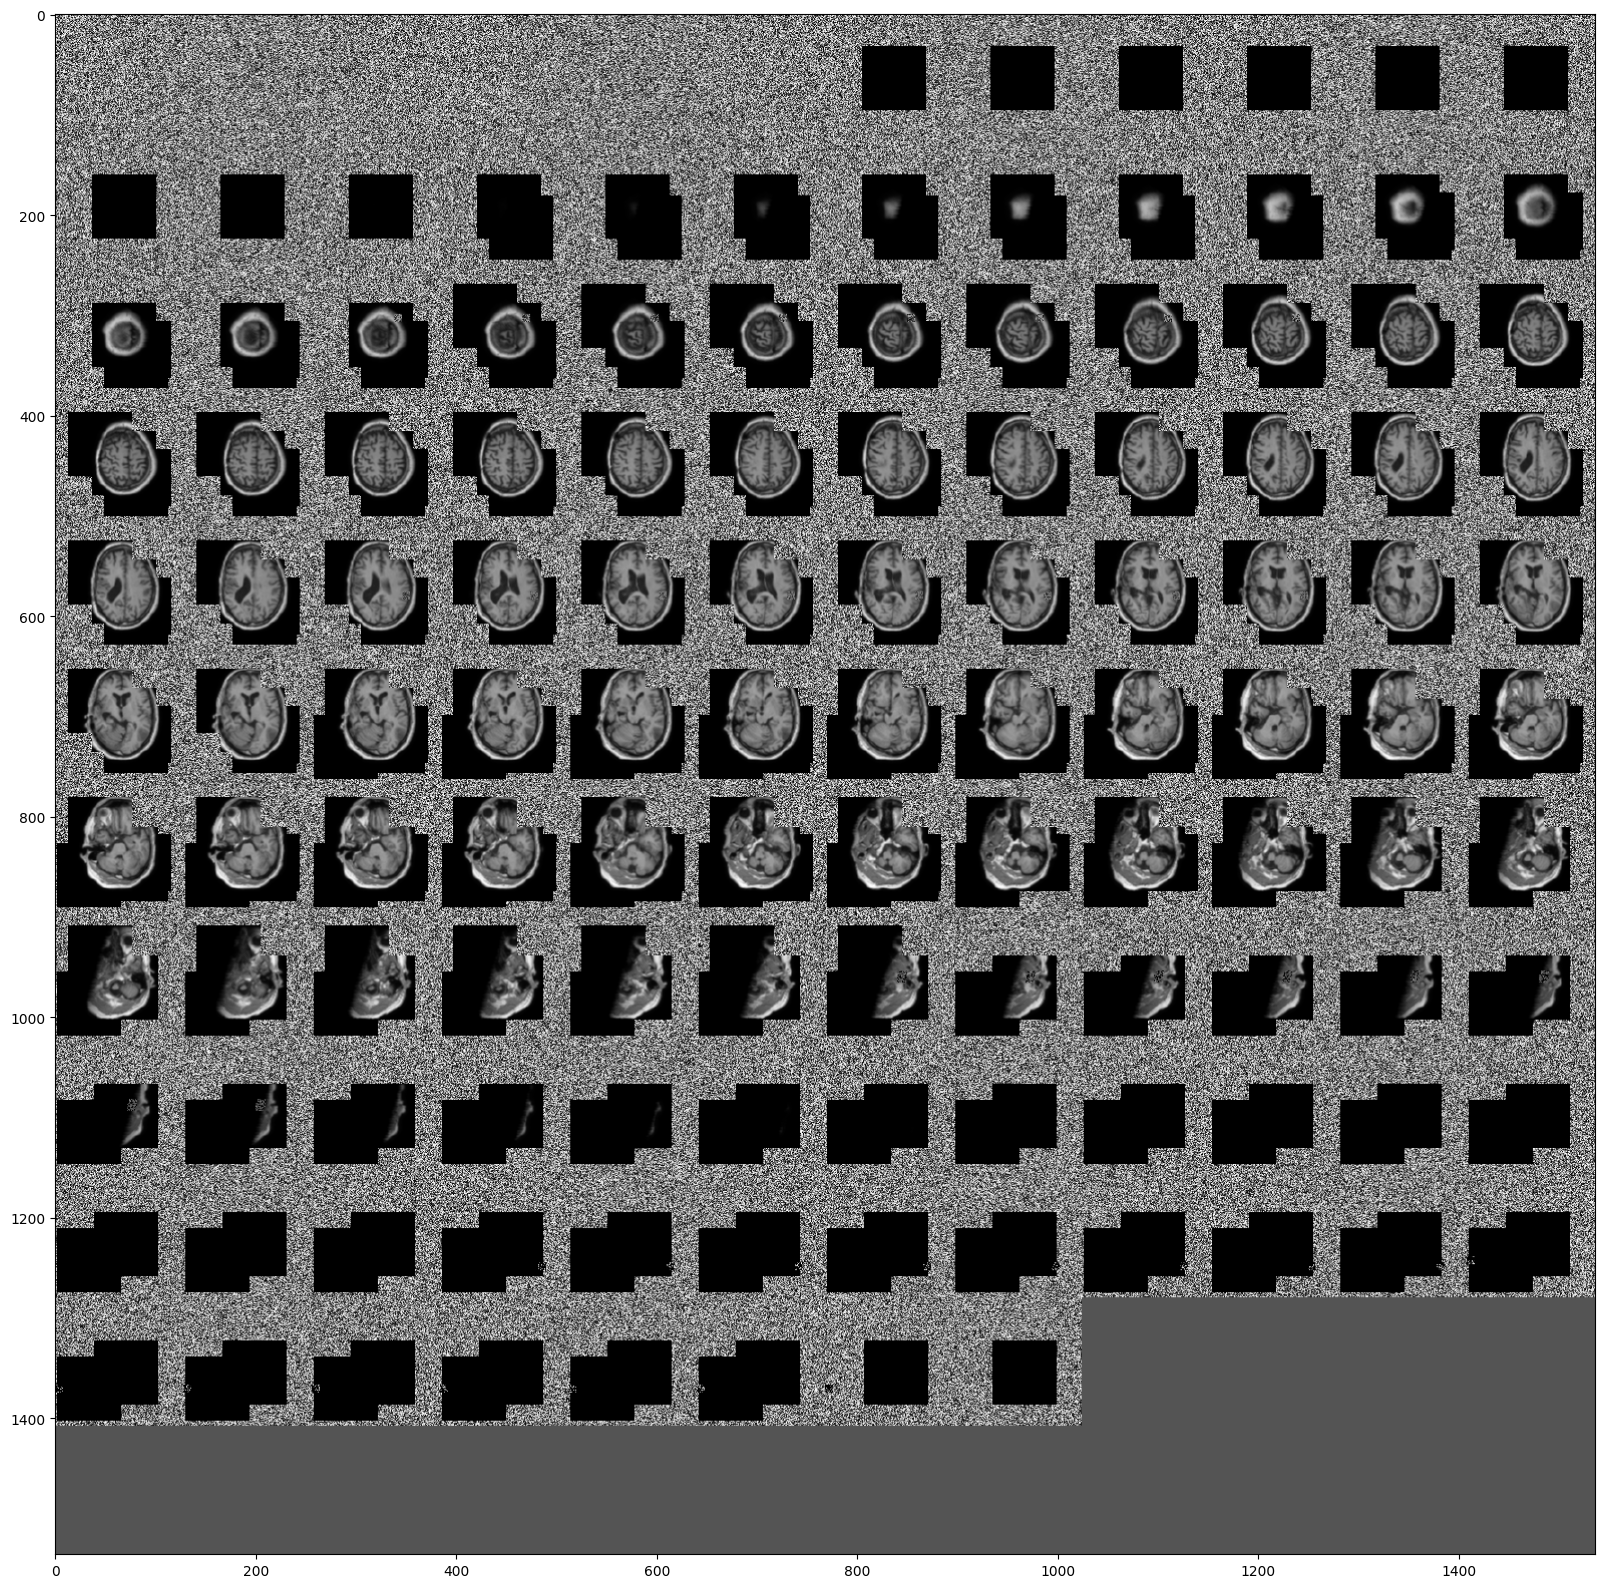

In [10]:
from skimage.util import montage
for val, i  in enumerate(check_loader):
    if(val % 5 == 0): continue
    img1 = i["image"]
    img2 = i["image_2"]
    img3 = i["gt_image"]
    break
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage(img1[0][0].permute(1, 2, 0)), cmap ='gray')

In [5]:
from collections.abc import Sequence
from monai.networks.blocks.patchembedding import PatchEmbeddingBlock
from monai.networks.blocks.transformerblock import TransformerBlock
from monai.networks.layers import Conv
from monai.utils import ensure_tuple_rep
from monai.networks.blocks.selfattention import SABlock

class CustomViTAutoEnc(nn.Module):
    def __init__(
        self,
        in_channels: int,
        img_size: Sequence[int] | int,
        patch_size: Sequence[int] | int,
        out_channels: int = 1,
        deconv_chns: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_layers: int = 12,
        num_heads: int = 12,
        pos_embed: str = "conv",
        dropout_rate: float = 0.0,
        spatial_dims: int = 3,
        qkv_bias: bool = False,
        save_attn: bool = False,
    ) -> None:
        super().__init__()

        self.patch_size = ensure_tuple_rep(patch_size, spatial_dims)
        self.spatial_dims = spatial_dims

        self.patch_embedding = PatchEmbeddingBlock(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=patch_size,
            hidden_size=384,     ### hidden size is halved because we have two inputs
            num_heads=num_heads,
            pos_embed=pos_embed,
            dropout_rate=dropout_rate,
            spatial_dims=self.spatial_dims,
        )
        self.blocks = nn.ModuleList(
            [
                TransformerBlock(hidden_size, mlp_dim, num_heads, dropout_rate, qkv_bias, save_attn)
                for i in range(num_layers)
            ]
        )
        self.norm = nn.LayerNorm(hidden_size)

        new_patch_size = [4] * self.spatial_dims
        conv_trans = Conv[Conv.CONVTRANS, self.spatial_dims]
        # self.conv3d_transpose* is to be compatible with existing 3d model weights.
        self.conv3d_transpose = conv_trans(hidden_size, deconv_chns, kernel_size=new_patch_size, stride=new_patch_size)
        self.conv3d_transpose_1 = conv_trans(
            in_channels=deconv_chns, out_channels=out_channels, kernel_size=new_patch_size, stride=new_patch_size
        )

        self.norm1 = nn.LayerNorm(hidden_size)
        self.patch_attn = SABlock(hidden_size, num_heads, dropout_rate, qkv_bias, save_attn)

    def forward(self, x1, x2):
        """
        Args:
            x: input tensor must have isotropic spatial dimensions,
                such as ``[batch_size, channels, sp_size, sp_size[, sp_size]]``.
        """
        spatial_size = x1.shape[2:]
        
        x1 = self.patch_embedding(x1)
        x2 = self.patch_embedding(x2)
        x = torch.cat([x1, x2], dim=2)

        # self attn
        x = x + self.patch_attn(self.norm1(x))

        hidden_states_out = []
        for blk in self.blocks:
            x = blk(x)
            hidden_states_out.append(x)
        
        x = self.norm(x)
        x = x.transpose(1, 2)
        d = [s // p for s, p in zip(spatial_size, self.patch_size)]
        x = torch.reshape(x, [x.shape[0], x.shape[1], *d])
        x = self.conv3d_transpose(x)
        x = self.conv3d_transpose_1(x)
        return x, hidden_states_out

##### Training Configuration

In [6]:
model = CustomViTAutoEnc(
    in_channels=1,
    img_size=(128, 128, 128),
    patch_size=(16, 16, 16),
    pos_embed="conv",
    hidden_size=768,
    mlp_dim=2048,
)

device = torch.device("cuda:0")
# model = nn.DataParallel(model, device_ids = [0, 1, 2])
model = model.to(device)

# Define Hyper-paramters for training loop
max_epochs = 500
val_interval = 2
batch_size = 1
lr = 1e-4
epoch_loss_values = []
step_loss_values = []
epoch_cl_loss_values = []
epoch_recon_loss_values = []
val_loss_values = []
best_val_loss = 1000.0

recon_loss = L1Loss()
contrastive_loss = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
# Define DataLoader using MONAI, CacheDataset needs to be used
train_ds_mri = Dataset(data=train_mris, transform=train_transforms)
train_loader_mri = DataLoader(train_ds_mri, batch_size=batch_size, shuffle=False, num_workers=4)

train_ds_ct = Dataset(data=train_cts, transform=train_transforms)
train_loader_ct = DataLoader(train_ds_ct, batch_size=batch_size, shuffle=False, num_workers=4)

val_ds_mri = Dataset(data=test_mris, transform=train_transforms)
val_loader_mri = DataLoader(val_ds_mri, batch_size=batch_size, shuffle=False, num_workers=4)

val_ds_ct = Dataset(data=test_cts, transform=train_transforms)
val_loader_ct = DataLoader(val_ds_ct, batch_size=batch_size, shuffle=False, num_workers=4)

##### Training loop with validation

In [ ]:
pbar = tqdm(range(max_epochs))
for epoch in pbar:
    pbar.set_description(f"epoch {epoch + 1}/{max_epochs}")
    pbar.refresh()
    model.train()
    epoch_loss = 0
    epoch_cl_loss = 0
    epoch_recon_loss = 0
    step = 0

    for mri_, ct_ in zip(train_loader_mri, train_loader_ct):
        step += 1
        start_time = time.time()

        # inputs, inputs_2, gt_input = (
        #     batch_data["image"].to(device),
        #     batch_data["image_2"].to(device),
        #     batch_data["gt_image"].to(device),
        # )

        mri_inputs, mri_inputs_2, mri_gt_input = (
            mri_["image"].to(device),
            mri_["image_2"].to(device),
            mri_["gt_image"].to(device),
        )

        ct_inputs, ct_inputs_2, ct_gt_input = (
            ct_["image"].to(device),
            ct_["image_2"].to(device),
            ct_["gt_image"].to(device),
        )

        optimizer.zero_grad()
        outputs_v1, hidden_v1 = model(mri_inputs, ct_inputs)
        outputs_v2, hidden_v2 = model(mri_inputs_2, ct_inputs_2)

        flat_out_v1 = outputs_v1.flatten(start_dim=1, end_dim=4)
        flat_out_v2 = outputs_v2.flatten(start_dim=1, end_dim=4)

        r_loss_mri = recon_loss(outputs_v1, mri_gt_input)
        r_loss_ct = recon_loss(outputs_v1, ct_gt_input)
        cl_loss = contrastive_loss(flat_out_v1, flat_out_v2)

        # Adjust the CL loss by Recon Loss
        r_loss = r_loss_mri + r_loss_ct
        total_loss = r_loss + cl_loss * r_loss

        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
        step_loss_values.append(total_loss.item())

        # CL & Recon Loss Storage of Value
        epoch_cl_loss += cl_loss.item()
        epoch_recon_loss += r_loss.item()

        end_time = time.time()
        # print(
        #     f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #     f"train_loss: {total_loss.item():.4f}, "
        #     f"time taken: {end_time-start_time}s"
        # )

    epoch_loss /= step
    epoch_cl_loss /= step
    epoch_recon_loss /= step

    epoch_loss_values.append(epoch_loss)
    epoch_cl_loss_values.append(epoch_cl_loss)
    epoch_recon_loss_values.append(epoch_recon_loss)
    # print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    pbar.set_description(f"epoch {epoch + 1}/{max_epochs} | loss: {epoch_loss:.4f}")
    pbar.refresh()

    if epoch % val_interval == 0:
        # print("Entering Validation for epoch: {}".format(epoch + 1))
        total_val_loss = 0
        val_step = 0
        model.eval()
        for mri_, ct_ in zip(val_loader_mri, val_loader_ct):
            val_step += 1
            start_time = time.time()

            mri_inputs, mri_gt_input = (
                mri_["image"].to(device),
                mri_["gt_image"].to(device),
            )

            ct_inputs, ct_gt_input = (
                ct_["image"].to(device),
                ct_["gt_image"].to(device),
            )

            outputs, outputs_v2 = model(mri_inputs, ct_inputs)
            r_loss_mri = recon_loss(outputs, mri_gt_input)
            r_loss_ct = recon_loss(outputs, ct_gt_input)

            val_loss = r_loss_mri + r_loss_ct
            total_val_loss += val_loss.item()
            end_time = time.time()

        total_val_loss /= val_step
        val_loss_values.append(total_val_loss)
        print(f"epoch {epoch + 1} Validation avg loss: {total_val_loss:.4f}, " f"time taken: {end_time-start_time}s")

        if total_val_loss < best_val_loss:
            print(f"Saving new model based on validation loss {total_val_loss:.4f} epoch {epoch + 1}")
            best_val_loss = total_val_loss
            checkpoint = {"epoch": epoch + 1, "state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            torch.save(checkpoint, os.path.join(LOG_ROOT, "best_model.pt"))

        plt.figure(1, figsize=(8, 8))
        plt.subplot(2, 2, 1)
        plt.plot(epoch_loss_values)
        plt.grid()
        plt.title("Training Loss")

        plt.subplot(2, 2, 2)
        plt.plot(val_loss_values)
        plt.grid()
        plt.title("Validation Loss")

        plt.subplot(2, 2, 3)
        plt.plot(epoch_cl_loss_values)
        plt.grid()
        plt.title("Training Contrastive Loss")

        plt.subplot(2, 2, 4)
        plt.plot(epoch_recon_loss_values)
        plt.grid()
        plt.title("Training Recon Loss")

        plt.savefig(os.path.join(LOG_ROOT, "loss_plots.png"))
        plt.close(1)

print("Done")
print(f"Saving new model based on validation loss {total_val_loss:.4f}")
checkpoint = {"epoch": max_epochs, "state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
torch.save(checkpoint, os.path.join(LOG_ROOT, "final_model.pt"))

In [22]:
data_root = os.path.normpath("/raid/deva/Task1/brain/")
logdir_path = os.path.normpath("/raid/deva/Task1/brain/logs")

masks = []; mris = []; cts = []
for x in os.listdir(data_root):
    if "mask" in x:
        masks.append(os.path.join(data_root, x))
    elif "mr" in x:
        mris.append(os.path.join(data_root, x))
    elif "ct" in x:
        cts.append(os.path.join(data_root, x))

# sort
all_train = mris + cts
masks = masks + masks
masks.sort(); mris.sort(); cts.sort(); all_train.sort()

t_data, v_data = train_test_split(all_train, test_size=0.1, random_state=123)


total = {"training": [], "validation": []}

for i in range(len(t_data)):
    total["training"].append({"image" : t_data[i]})

for i in range(len(v_data)):
    total["validation"].append({"image" : v_data[i]})

if os.path.exists(logdir_path) is False:
    os.mkdir(logdir_path)

mri_total = {"training": [], "validation": []}
ct_total = {"training": [], "validation": []}

for i in range(len(t_data)):
    total["training"].append({"image" : t_data[i]})

for i in range(len(v_data)):
    total["validation"].append({"image" : v_data[i]})

# split train/val

train_data = total["training"]
val_data = total["validation"]

for idx, _each_d in enumerate(train_data):
    train_data[idx]["image"] = os.path.join(data_root, train_data[idx]["image"])

for idx, _each_d in enumerate(val_data):
    val_data[idx]["image"] = os.path.join(data_root, val_data[idx]["image"])

print("Total Number of Training Data Samples: {}".format(len(train_data)))
print("Total Number of Validation Data Samples: {}".format(len(val_data)))

Total Number of Training Data Samples: 648
Total Number of Validation Data Samples: 72


In [24]:
with open(os.path.join("/raid/deva/logs/pre_train/swin", "train_data.json"), "w") as fp:
    json.dump(train_data, fp)


In [33]:
with open(os.path.join("./jsons", "val_data.json"), "w") as fp:
    json.dump(val_data, fp)